Upload basic libraries and read csv train and test file

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle 

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

To effectively address the missing values in both documents, it is necessary to utilize the 'isna' function

In [2]:
print(df_train.isna().sum().sort_values())
print(df_test.isna().sum().sort_values())


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
Age            177
Cabin          687
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Embarked         0
Fare             1
Age             86
Cabin          327
dtype: int64


To handle the missing values for the "Age" and "Fare" variables in both the train and test sets, it is necessary to impute these missing values using the strategies of "mean" and "most frequent". Subsequently, these imputed values can be replaced in the respective dataframes, df_train and df_test. This process ensures that the missing values in both datasets are effectively addressed, providing more complete and reliable data for further analysis.

In [3]:
from sklearn.impute import SimpleImputer

#Impuration of age variable in test set
X_age = df_test["Age"].values.reshape(-1, 1)

imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer = imputer.fit(X_age)
X_age = imputer.transform(X_age)


# Assign the imputed values back to the DataFrame
df_test["Age"] = X_age.flatten()

#Impuration of Fate variable in test set
X_fare = df_test["Fare"].values.reshape(-1, 1)

imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer = imputer.fit(X_fare)
X_fare = imputer.transform(X_fare)


# Assign the imputed values back to the DataFrame
df_test["Fare"] = X_fare.flatten()

#Impuration of age variable in train set
X_age_train = df_train["Age"].values.reshape(-1, 1)

imputer = SimpleImputer(strategy='most_frequent', missing_values=np.nan)
imputer = imputer.fit(X_age_train)
X_age_train = imputer.transform(X_age_train)


# Assign the imputed values back to the DataFrame
df_train["Age"] = X_age_train.flatten()

After performing the imputation process, it is recommended to conduct another check to ensure the effectiveness of the imputation. By examining the document once more via .isna function to verify if the imputation successfully filled in the previously empty fields. 

In [4]:
print(df_train.isna().sum().sort_values())
print(df_test.isna().sum().sort_values())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
Cabin          687
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
Cabin          327
dtype: int64


To gain insights into the correlations between variables, it is beneficial to generate a correlation heat map. By plotting this heat map, you can visualize the strength of the relationships between different variables. 

/var/folders/fp/rgbj4wss58jdy82pc16ndy5h0000gn/T/ipykernel_21258/196388433.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_train.corr(), annot=True,cmap="RdBu")


Text(0.5, 1.0, 'Correlations')

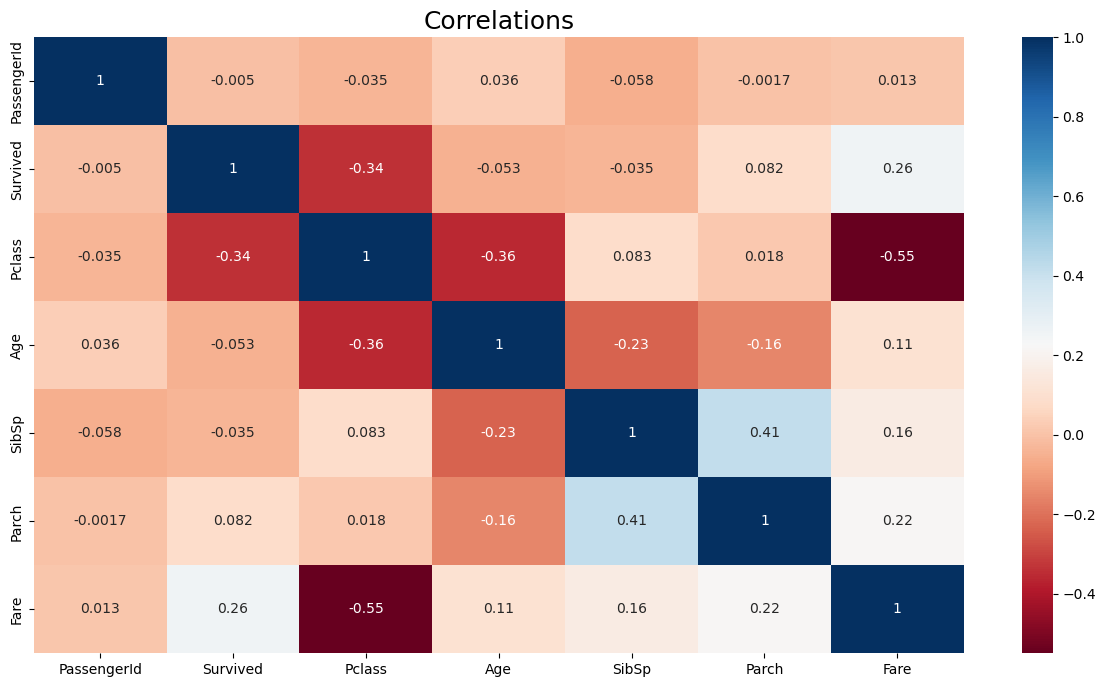

In [5]:
import seaborn as sns 
import matplotlib.pyplot as plt 
plt.subplots(figsize = (15,8))
sns.heatmap(df_train.corr(), annot=True,cmap="RdBu")
plt.title("Correlations", fontsize = 18)

Before utilizing machine learning algorithms, it is crucial to define and scale the variables appropriately. 

In [6]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

le = LabelEncoder()
df_train["Sex"] = le.fit_transform(df_train["Sex"])

features = ["Pclass", "Sex", "Age","SibSp", "Parch", "Fare"]

y = df_train["Survived"]
X = df_train[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Train machine learning algorithms including Linear Logistics, KNN (K-Nearest Neighbors), Random Forest, and SVM (Support Vector Machines), and then utilize the VotingClassifier as a meta model,

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import xgboost as xgb


SEED = 1

# Splitting the training set into smaller training set and validation set
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.30,random_state=SEED)

# Decision tree classifier
knn = KNN(n_neighbors=15)
lr = LogisticRegression(C=0.1)
rf = RandomForestClassifier(n_estimators=100,min_samples_leaf=4,max_features="log2")
svm = SVC(C= 1, kernel= 'rbf')
xgb_clf = xgb.XGBClassifier(learning_rate=0.3, max_depth= 5, n_estimators=150)

classifiers = [('Logistic Regression', lr),
               ('KNearestNeighbours', knn),
               ('Random Forest', rf),
               ('Support Vector Machine', svm),
               ('XGBoost', xgb_clf)]

# Train and evaluate classifiers on the validation set
for clf_name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('{:s} : {:.3f}'.format(clf_name, accuracy_score(y_test, y_pred)))

# Train the voting classifier on the full training set
vc = VotingClassifier(estimators=classifiers)
vc.fit(X_train, y_train)
y_pred_vc = vc.predict(X_test)

print('Print Voting Classifier: {:.3f}'.format(accuracy_score(y_test, y_pred_vc)))

Logistic Regression : 0.769
KNearestNeighbours : 0.780
Random Forest : 0.787
Support Vector Machine : 0.799
XGBoost : 0.769
Print Voting Classifier: 0.787


Additional meta model known as the Stacking Classifier can be incorporated. This model allows for a comprehensive assessment of the performance enabling a thorough comparison with previous voting classifier.

In [8]:
from sklearn.ensemble import StackingClassifier

# Initialize the StackingClassifier with the base classifiers
stacking_clf = StackingClassifier(estimators=classifiers, final_estimator=LogisticRegression())
stacking_clf.fit(X_train, y_train)

y_pred_stacking = stacking_clf.predict(X_test)

print('Stacking Classifier: {:.3f}'.format(accuracy_score(y_test, y_pred_stacking)))

Stacking Classifier: 0.795


To perform hyperparameter tuning using GridSearchCV, various machine learning algorithms such as KNN, Random Forest, Logistic Regression, SVM, and XGBoost can be optimized. By leveraging GridSearchCV, an extensive search over predefined hyperparameter grids can be conducted to identify the best combination of hyperparameters for each algorithm. This process ensures that the models are fine-tuned and optimized, ultimately enhancing their predictive performance and overall effectiveness

In [9]:
from sklearn.model_selection import GridSearchCV
params_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15]}


grid_knn = GridSearchCV(estimator=knn,
                        param_grid=params_knn,
                        scoring='accuracy',
                        cv=10,
                        n_jobs=-1)


grid_knn.fit(X_train, y_train)


best_hyperparams_knn = grid_knn.best_params_
print(best_hyperparams_knn)

{'n_neighbors': 3}


In [10]:
params_rf = {
    'n_estimators': [100, 200, 300, 400],
    'min_samples_leaf': [2, 4, 6, 8],
    'max_features': ['sqrt', 'log2']}

grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       scoring='accuracy',
                       cv=10,
                       n_jobs=-1)

grid_rf.fit(X_train, y_train)

best_hyperparams_rf = grid_rf.best_params_
print(best_hyperparams_rf)

{'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 100}


In [11]:
params_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
             }

grid_svm = GridSearchCV(estimator=svm,
                        param_grid=params_svm,
                        scoring='accuracy',
                        cv=10,
                        n_jobs=-1)


grid_svm.fit(X_train, y_train)

best_hyperparams_svm = grid_svm.best_params_

print(best_hyperparams_svm)

{'C': 1, 'kernel': 'rbf'}


In [12]:
params_lr = {
    'C': [0.1, 1, 5, 10],
            }

grid_lr = GridSearchCV(estimator=lr,
                       param_grid=params_lr,
                       scoring='accuracy',
                       cv=10,
                       n_jobs=-1)


grid_lr.fit(X_train, y_train)


best_hyperparams_lr = grid_lr.best_params_
print(best_hyperparams_lr)

{'C': 0.1}


In [13]:
# Define the parameter grid
params_xgb = {
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 150]
}

# Create an instance of the XGBoost classifier
xgb_clf = xgb.XGBClassifier()

# Create the grid search object
grid_xgb = GridSearchCV(estimator=xgb_clf,
                        param_grid=params_xgb,
                        scoring='accuracy',
                        cv=10,
                        n_jobs=-1)

# Fit the grid search to the training data
grid_xgb.fit(X_train, y_train)

# Get the best hyperparameters found by the grid search
best_hyperparams_xgb = grid_xgb.best_params_
print(best_hyperparams_xgb)

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [14]:
y_pred_xg = grid_xgb.predict(X_test)

In [15]:
print('XG BOOST Classifier: {:.3f}'.format(accuracy_score(y_test, y_pred_xg)))

XG BOOST Classifier: 0.772


Testframe is appropriately scaled, and then it can be fed into the stacking_clf model for predictions and evaluation. This step allows for a fair and accurate assessment of the model's performance on unseen data.

In [16]:
le = LabelEncoder()
df_test["Sex"] = le.fit_transform(df_test["Sex"])

testframe = df_test[features]

testframe_scaled = scaler.transform(testframe)

#Stacking is the trained VotingClassifier
y_pred = stacking_clf.predict(testframe_scaled)

temp = pd.DataFrame({
    "PassengerId": df_test["PassengerId"],
    "Survived": y_pred})

print(temp)

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


In [17]:
stacking_clf

StackingClassifier(estimators=[('Logistic Regression',
                                LogisticRegression(C=0.1)),
                               ('KNearestNeighbours',
                                KNeighborsClassifier(n_neighbors=15)),
                               ('Random Forest',
                                RandomForestClassifier(max_features='log2',
                                                       min_samples_leaf=4)),
                               ('Support Vector Machine', SVC(C=1)),
                               ('XGBoost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              cols...
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.3, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=150, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...))],
                   final_estimator=LogisticRegression())

In [18]:
import pickle

In [19]:
with open('model.pickle', 'wb') as f:
    pickle.dump(stacking_clf, f)

In [20]:
with open('model.pickle','rb') as f:
    stacking_clf = pickle.load(f)

In [21]:
with open('model_scaler.pickle','wb') as f:
    pickle.dump(scaler,f)

In [23]:
scaler.fit_transform(testframe)

array([[ 0.87348191,  0.75592895,  0.3349926 , -0.49947002, -0.4002477 ,
        -0.49840706],
       [ 0.87348191, -1.32287566,  1.32553003,  0.61699237, -0.4002477 ,
        -0.51327429],
       [-0.31581919,  0.75592895,  2.51417495, -0.49947002, -0.4002477 ,
        -0.46508846],
       ...,
       [ 0.87348191,  0.75592895,  0.65196458, -0.49947002, -0.4002477 ,
        -0.50879189],
       [ 0.87348191,  0.75592895,  0.        , -0.49947002, -0.4002477 ,
        -0.4944482 ],
       [ 0.87348191,  0.75592895,  0.        ,  0.61699237,  0.61989583,
        -0.23790598]])

In [24]:
X_test

array([[-1.56610693, -1.35557354,  1.4730739 , -0.4745452 , -0.47367361,
        -0.12634532],
       [ 0.82737724,  0.73769513, -0.3461881 , -0.4745452 , -0.47367361,
        -0.48944219],
       [-0.36936484, -1.35557354, -0.87680619, -0.4745452 , -0.47367361,
        -0.43700744],
       ...,
       [-0.36936484,  0.73769513,  0.33603515, -0.4745452 , -0.47367361,
        -0.40126837],
       [-1.56610693,  0.73769513, -0.27038552,  0.43279337, -0.47367361,
         1.18542955],
       [-1.56610693,  0.73769513,  1.32146873,  0.43279337, -0.47367361,
         0.58331784]])

In [25]:
stacking_clf.predict(X_test)

array([1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0])

In [30]:
X

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,1,22.0,1,0,7.2500
1,1,0,38.0,1,0,71.2833
2,3,0,26.0,0,0,7.9250
3,1,0,35.0,1,0,53.1000
4,3,1,35.0,0,0,8.0500
...,...,...,...,...,...,...
886,2,1,27.0,0,0,13.0000
887,1,0,19.0,0,0,30.0000
888,3,0,24.0,1,2,23.4500
889,1,1,26.0,0,0,30.0000


In [26]:
X_scaled

array([[ 0.82737724,  0.73769513, -0.49779327,  0.43279337, -0.47367361,
        -0.50244517],
       [-1.56610693, -1.35557354,  0.71504807,  0.43279337, -0.47367361,
         0.78684529],
       [ 0.82737724, -1.35557354, -0.19458293, -0.4745452 , -0.47367361,
        -0.48885426],
       ...,
       [ 0.82737724, -1.35557354, -0.3461881 ,  0.43279337,  2.00893337,
        -0.17626324],
       [-1.56610693,  0.73769513, -0.19458293, -0.4745452 , -0.47367361,
        -0.04438104],
       [ 0.82737724,  0.73769513,  0.26023257, -0.4745452 , -0.47367361,
        -0.49237783]])

In [28]:
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [29]:
scaler.fit_transform(np.array(testframe.iloc[9]).reshape(1,-1))

array([[0., 0., 0., 0., 0., 0.]])